In [ ]:
!pip install --upgrade git+https://github.com/huggingface/transformers.git

In [3]:
import transformers
import pandas as pd
import re
import numpy as np
import tensorboard as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from transformers import pipeline

In [20]:
ann_dt = pd.read_csv('annotated_dataset.csv', index_col=0)

# remove empty strings
to_rm = ann_dt[ann_dt['tweet'].str.isspace()].index.to_list()
ann_dt = ann_dt.drop(index=to_rm)

ann_dt.head(10)

,tweet,category
id,,
6429,"Come ho sempre detto, destra sinistra la cosa...",Non-Hateful
14736,Bravo,Non-Hateful
17964,Ipocrita,Non-Hateful
18948,ma vaffunculo stronzo di merda,Hateful
303,E dire che basterebbe semplicemente votare PD...,Non-Hateful
311,Cos'è : Ursula Dessert?,Non-Hateful
31829,Che hai detto?????,Non-Hateful
34841,Addirittura,Non-Hateful
325,"A parte tutte le polemiche,sarebbe sufficient...",Non-Hateful


In [21]:
# load the policycorpus data (Duzha et al, 2021)
pctest = pd.read_csv('policycorpus-test.csv', index_col=0)
pctrain = pd.read_csv('policycorpus-training.csv', index_col=0)

In [22]:
# combine my annotated dataset + policycorpus dataset
pc = pd.concat([pctest, pctrain])
pc['class'] = np.where(pc['class'] == 'n', 'Non-Hateful', 'Hateful')
pc = pc.rename(columns={'text':'tweet', 'class':'category'})
pc_ann_dt = pd.concat([pc, ann_dt])
pc_ann_dt

,tweet,category
id,,
1001,Poi vi scandalizzate se vi paragonano ai nazif...,Non-Hateful
1002,Porto il numero tre sulla maglia. Il numero tr...,Non-Hateful
1003,Possiamo archiviare per un po qs #esaltata che...,Non-Hateful
1004,Possiamo dirlo che la #legge sul divieto per #...,Non-Hateful
1005,Possibile non si possa punire pesantemente que...,Non-Hateful
...,...,...
9455,Vanno condannate simili atti,Non-Hateful
15786,Cialtrona,Hateful
22421,Sciacallo,Hateful


In [33]:
def load_data(filename):
    df = pd.read_csv(filename, index_col=0)
    return df

def preprocess_tweet(tweet):
    tweet = str(tweet)
    # Remove URLs, RTs, and twitter handles
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Lowercase text
    tweet = tweet.lower() 
    return tweet

def build_model(df, model, vectorizer=None):
    # Preprocess text data
    df["tweet"] = df["tweet"].apply(preprocess_tweet)
    
    # Split data into training and testing sets
    X = df["tweet"]
    y = df["category"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)
    
    if model in ["naive_bayes", "random_forest", "xgboost", "logistic_regression"]:
        # Vectorize the text data
        if vectorizer == "count":
            vectorizer = CountVectorizer()
        elif vectorizer == "tfidf":
            vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        
        # Train and evaluate the model
        if model == "naive_bayes":
            clf = MultinomialNB()
        elif model == "random_forest":
            clf = RandomForestClassifier()
        elif model == "xgboost":
            clf = XGBClassifier()
            y_train = np.where(y_train == 'Hateful', 1, 0)
            y_test = np.where(y_test == 'Hateful', 1, 0)
        elif model == "logistic_regression":
            clf = LogisticRegression()

        clf.fit(X_train, y_train)
        print(f"Model: {model}")
        accuracy = clf.score(X_test, y_test)
        print(f"Accuracy: {accuracy}")
        
        # Perform cross-validation
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        print(f"Cross Validation Score: {scores.mean()}")
        print("---------------------------------------")
        return accuracy, scores.mean()
    
    elif model in ['MilaNLProc/hate-ita', 'MilaNLProc/hate-ita-xlm-r-base', 'MilaNLProc/hate-ita-xlm-r-large']:
        classifier = pipeline("text-classification",model=model,top_k=2)

        # Get the predictions for the test set
        predictions = []
        for text in X_test:
            prediction = classifier(text)[0][0]['label']
            if prediction == 'non-hateful':
                prediction = 'Non-Hateful'
            else:
                prediction = 'Hateful'
            predictions.append(prediction)
        accuracy = accuracy_score(y_test, predictions)

        print(f"Model: {model}")
        print(f"Accuracy: {accuracy:.4f}")
        print("---------------------------------------")
        return accuracy, np.nan

results = []
models = ["naive_bayes", "random_forest", "xgboost", "logistic_regression"]
models_2 = ['MilaNLProc/hate-ita', 'MilaNLProc/hate-ita-xlm-r-base', 'MilaNLProc/hate-ita-xlm-r-large']
vectorizations = ["count", "tfidf"]

for model in models:
    for vec in vectorizations:
        accuracy, cv_score = build_model(pc_ann_dt, model, vec)
        results.append([model, vec, accuracy, cv_score])

for model in models_2:
    # no need for vectorization
    accuracy, cv_score = build_model(pc_ann_dt, model)
    results.append([model, 'NaN', accuracy, cv_score])
        


Model: naive_bayes
Accuracy: 0.8429752066115702
Cross Validation Score: 0.7944441535319683
---------------------------------------
Model: naive_bayes
Accuracy: 0.837465564738292
Cross Validation Score: 0.8115777347227313
---------------------------------------
Model: random_forest
Accuracy: 0.8443526170798898
Cross Validation Score: 0.8174844216369064
---------------------------------------
Model: random_forest
Accuracy: 0.8360881542699724
Cross Validation Score: 0.8163027351590999
---------------------------------------
Model: xgboost
Accuracy: 0.8388429752066116
Cross Validation Score: 0.8151245396310065
---------------------------------------
Model: xgboost
Accuracy: 0.8388429752066116
Cross Validation Score: 0.8163062261088129
---------------------------------------
Model: logistic_regression
Accuracy: 0.8457300275482094
Cross Validation Score: 0.8198512855422317
---------------------------------------
Model: logistic_regression
Accuracy: 0.837465564738292
Cross Validation Score: 0

In [127]:
import transformers
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

MAX_LENGTH = 256
pc_ann_dt['category_n'] = np.where(pc_ann_dt['category'] == 'Non-Hateful', 0, 1)
pc_ann_dt['tweet'] = pc_ann_dt['tweet'].apply(lambda x: preprocess_tweet(x))

# Load the annotated dataset
texts = pc_ann_dt['tweet'].to_list() # List of texts
labels = pc_ann_dt['category_n'].to_list() # List of labels (0 for non-hateful, 1 for hateful)

# Load the pre-trained tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("MilaNLProc/hate-ita-xlm-r-large")

# Convert texts and labels to input_ids and labels using the tokenizer
input_ids = [tokenizer.encode(text, add_special_tokens=True, max_length=MAX_LENGTH) for text in texts]

# Pad input_ids so that they have the same length
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAX_LENGTH, dtype="long", value=0, padding="post", truncating="post")

# Convert labels to numpy array
labels = np.array(labels)

# Split data into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=1, test_size=0.30)

# Convert inputs and labels to tensors
train_inputs = tf.constant(train_inputs, dtype=tf.int32)
validation_inputs = tf.constant(validation_inputs, dtype=tf.int32)
train_labels = tf.constant(train_labels, dtype=tf.int32)

# Load the pre-trained PyTorch model
model = transformers.TFBertForSequenceClassification.from_pretrained('MilaNLProc/hate-ita-xlm-r-large', from_pt=True)

# Freeze the base model layer (bert)
model.bert.trainable = False

# Remove the last layer
model.classifier = None

# Add a new layer for your specific task
model.classifier = tf.keras.layers.Dense(units=2, activation='softmax')

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create a TensorFlow data adapter
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_labels)).batch(32)

with tf.device("GPU:0"): # change the GPU index based on your setup
    # Train the model using your task-specific data
    history = model.fit(train_dataset, epochs=2, validation_data=validation_dataset)

# Evaluate the model on the validation set
test_loss, test_accuracy = model.evaluate(validation_dataset)

# Print the overall metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['roberta.encoder.layer.3.intermediate.dense.weight', 'roberta.encoder.layer.15.attention.self.query.weight', 'roberta.encoder.layer.19.output.dense.weight', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.10.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.5.attention.self.query

Epoch 1/2
53/53 [==============================] - 45s 410ms/step - loss: 0.5404 - accuracy: 0.7933 - val_loss: 0.5293 - val_accuracy: 0.8044
Epoch 2/2
23/23 [==============================] - 4s 182ms/step - loss: 0.5414 - accuracy: 0.8044
Test Loss: 0.5414384603500366
Test Accuracy: 0.8044077157974243


In [128]:
results.append(['hate-ita-xlm-r-large-fine-tuned', np.nan, test_accuracy, np.nan])

In [129]:
df_results = pd.DataFrame(results, columns=["model", "vectorization", "accuracy", "cv_score"])
df_results.to_csv("results.csv", index=False)

In [130]:
df_results.sort_values(by='accuracy', ascending=False)

,model,vectorization,accuracy,cv_score
6,logistic_regression,count,0.845730,0.819851
2,random_forest,count,0.844353,0.817484
0,naive_bayes,count,0.842975,0.794444
4,xgboost,count,0.838843,0.815125
5,xgboost,tfidf,0.838843,0.816306
1,naive_bayes,tfidf,0.837466,0.811578
7,logistic_regression,tfidf,0.837466,0.812166
3,random_forest,tfidf,0.836088,0.816303
11,hate-ita-xlm-r-large-fine-tuned,NaN,0.804408,NaN
10,MilaNLProc/hate-ita-xlm-r-large,NaN,0.691460,NaN


In [119]:
replies = pd.read_csv('all_replies.csv', index_col=0)

In [120]:
def preprocess_tweet(tweet):
    tweet = str(tweet)
    # Remove URLs, RTs, and twitter handles
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Lowercase text
    tweet = tweet.lower() 
    return tweet

In [127]:
# Split data into features (text) and labels (hate speech or not)
texts = pc_ann_dt['tweet'].apply(preprocess_tweet)
labels = pc_ann_dt['category'].values

# Convert text to numerical feature vectors using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Train the Logistic Regression model using cross-validation
clf_lr = LogisticRegression()
clf_lr.fit(X, labels)

# Load the new dataframe with tweets
new_df = replies

# Step 4: Preprocess the tweets in the new dataframe
new_texts = new_df['reply'].apply(preprocess_tweet)

# Step 5: Convert the new tweets to numerical feature vectors
new_X = vectorizer.transform(new_texts)

# Step 6: Make predictions on the new dataframe
predictions = clf_lr.predict(new_X)



In [128]:
replies['hate'] = predictions

In [129]:
replies[replies['hate'] == 'Hateful'].head(5)

,source_tweet,reply,hate
0,1610630350279004160,"Oggi sei particolarmente scatenato, non ries...",Hateful
2,1610630350279004160,E adesso aspettiamo con ansia cosa ne pensa Or...,Hateful
28,1610533803910463488,Ascani ma vaffanculo… ma perché non lo avete ...,Hateful
45,1610533803910463488,Ascani non dire cazzate come tuo solito ...,Hateful
50,1610533803910463488,Ogni giorno appare qualche emerito sconosciut...,Hateful


In [130]:
len(replies[replies['hate'] == 'Hateful'])

11248

In [131]:
replies.to_csv('all_replies_hs.csv', index=False)

In [132]:
# Load the dataframe of tweets
tweets = pd.read_csv('all_tweets_19L.csv', index_col=0) 

# Filter the dataframe based on the time column
tweets = tweets[tweets["Time"] >= '2023-01-02 00:00:00+00:00']

classifier = pipeline("text-classification",model='MilaNLProc/feel-it-italian-sentiment',top_k=3)


def get_sentiment(tweet):
    if type(tweet) is not str:
        return np.nan
    prediction = classifier(tweet)[0][0]
    return prediction['label']

tweets['Tweet'] = tweets['Tweet'].apply(preprocess_tweet)
tweets['Sentiment'] = tweets['Tweet'].apply(get_sentiment)

In [133]:
tweets.to_csv('all_tweets_sentiment.csv')

In [134]:
tweets

,Tweet_ID,Time,User,Tweet,Sentiment
0,1614929198455332864,2023-01-16 10:14:59+00:00,DavideAiello85,finalmente dopo 30 anni finisce la latitanza d...,negative
1594,1619970156603781120,2023-01-30 08:05:57+00:00,amendolaenzo,giovanni lettieri sindaco di picerno candidato...,positive
1595,1619694030069309440,2023-01-29 13:48:43+00:00,amendolaenzo,il decretoong è profondamente sbagliato una ma...,negative
1596,1619293651200516096,2023-01-28 11:17:46+00:00,amendolaenzo,gravi gli attacchi alle sedi diplomatiche ital...,negative
1597,1618882526122217474,2023-01-27 08:04:06+00:00,amendolaenzo,nei campi di sterminio rimasi sola e non rivid...,negative
...,...,...,...,...,...
200114,1613304423345979392,2023-01-11 22:38:42+00:00,eugenio_zoffili,con orgoglio e un po di emozione oggi nella se...,positive
200115,1611868863779446784,2023-01-07 23:34:18+00:00,eugenio_zoffili,qui si sta realizzando unopera che conta più d...,positive
200116,1611868573093474305,2023-01-07 23:33:09+00:00,eugenio_zoffili,oggi a casalpusterlengo lo nel comune del nost...,positive
200117,1611782683708858372,2023-01-07 17:51:51+00:00,eugenio_zoffili,vi aspettiamo a como con matteo salvini \npren...,positive


In [135]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from transformers import pipeline
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [177]:
replies = pd.read_csv('all_replies_hs.csv', index_col=0)
accounts = pd.read_csv('twitter_veracc.csv', index_col=0)
tweets = pd.read_csv('all_tweets_sentiment.csv', index_col=0)

In [178]:
replies = replies.rename(columns={'hate':'Hate_score'})

accounts['parliamentary_group'] = accounts['parliamentary_group'].replace({
    'Movimento 5 Stelle':'M5S', 
    'Partito Democratico':'PD',
    'Lega':'LEGA',
    "Fratelli d'Italia":'FDI', 
    'Azione - Italia Viva':'AzIV'
})

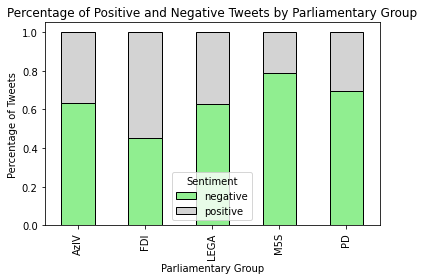

In [179]:
import matplotlib.pyplot as plt
import pandas as pd

sent = pd.merge(accounts, tweets, left_on='screen_name', right_on='User')

# Group the dataframe by parliamentary_group and sentiment
grouped = sent.groupby(["parliamentary_group", "Sentiment"]).size().reset_index(name="count")

# Pivot the grouped dataframe to create a new dataframe with the sentiment as columns and parliamentary_group as index
pivot = grouped.pivot(index="parliamentary_group", columns="Sentiment", values="count")

# Fill missing values with 0
pivot = pivot.fillna(0)

# Calculate the total number of tweets for each parliamentary_group
total_tweets = pivot.sum(axis=1)

# Calculate the percentage of tweets with each sentiment for each parliamentary_group
pivot["positive"] = pivot["positive"] / total_tweets
pivot["negative"] = pivot["negative"] / total_tweets

# Plot the bar chart
fig, ax = plt.subplots(figsize=(6, 4))
pivot.plot.bar(ax=ax, stacked=True, color=["lightgreen", "lightgrey", "red"], edgecolor="black")
ax.set_xlabel("Parliamentary Group")
ax.set_ylabel("Percentage of Tweets")
ax.set_title("Percentage of Positive and Negative Tweets by Parliamentary Group")
ax.legend(title="Sentiment", loc="best")
plt.tight_layout()
plt.show()

In [180]:
pivot.round(4).multiply(100)

Sentiment,negative,positive
parliamentary_group,,
AzIV,63.56,36.44
FDI,45.43,54.57
LEGA,63.04,36.96
M5S,78.76,21.24
PD,69.68,30.32


In [181]:
# merge the tweets and replies dataframes on 'source_tweet' column
merged_df = pd.merge(replies, tweets, left_on='source_tweet', right_on='Tweet_ID')

# merge the resulting dataframe with the accounts dataframe on 'User' column
final_df = pd.merge(merged_df, accounts, left_on='User', right_on='screen_name')

# select columns from final dataframe
final_df = final_df[['Tweet_ID', 'Hate_score', 'followers_count', 'gender', 'parliamentary_group', 'Sentiment']]
final_df = final_df.dropna()
#final_df['Hate_score'] = np.where(final_df['Hate_score'] > 0.5, 1,0)

In [182]:
final_df.to_csv('final.csv', index=False)

In [183]:
# Load the data into a pandas dataframe
df = final_df
#df['Hate_score'] = np.where(df['Hate_score'] > 0.5, 'Hateful', 'Non_Hateful')

# Create a contingency table for the relationship between gender and Hate_score
gender_Hate_table = pd.crosstab(df["gender"], df["Hate_score"])
chi2, p_val, dof, expected = stats.chi2_contingency(gender_Hate_table)
print("Chi-squared test results for gender and Hate_score: chi2 =", chi2, "and p-value =", p_val)

# Create a contingency table for the relationship between parliamentary_group and Hate_score
parliamentary_group_Hate_table = pd.crosstab(df["parliamentary_group"], df["Hate_score"])
chi2, p_val, dof, expected = stats.chi2_contingency(parliamentary_group_Hate_table)
print("Chi-squared test results for parliamentary_group and Hate_score: chi2 =", chi2, "and p-value =", p_val)

Chi-squared test results for gender and Hate_score: chi2 = 0.18720147505021245 and p-value = 0.6652560839864929
Chi-squared test results for parliamentary_group and Hate_score: chi2 = 68.01138627387822 and p-value = 5.965595448529471e-14


The results of the chi-squared test indicate that there is a significant relationship between the "Hate_score" variable and the "parliamentary_group" variable. (p-values < 0.05). This suggests that the distribution of "Hateful" and "Non-Hateful" scores is not the same across the different groups defined by "gender". 

The p-value for the relationship between "parliamentary_group" and "Hate_score" is {p_val}, much smaller than 0.05, so we can reject the null hypothesis that the distribution of "Hateful" and "Non-Hateful" scores is the same for the different parliamentary groups.

There is no significant association between gender and hate speech in replies.

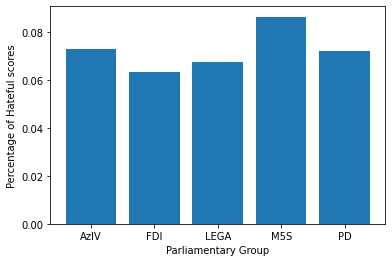

,parliamentary_group,Hate_score
0,AzIV,7.28
1,FDI,6.34
2,LEGA,6.76
3,M5S,8.64
4,PD,7.19


In [184]:
# select columns from final dataframe
df = final_df[['Tweet_ID', 'Hate_score', 'followers_count', 'gender', 'parliamentary_group']]
grouped = df.groupby("parliamentary_group")["Hate_score"].apply(lambda x: (x == "Hateful").mean()).reset_index()
# Plot the percentage of "Hateful" scores for each gender
plt.bar(grouped["parliamentary_group"], grouped["Hate_score"])
plt.xlabel("Parliamentary Group")
plt.ylabel("Percentage of Hateful scores")
plt.show()
grouped['Hate_score'] = grouped['Hate_score'].multiply(100).round(2)
display(grouped)

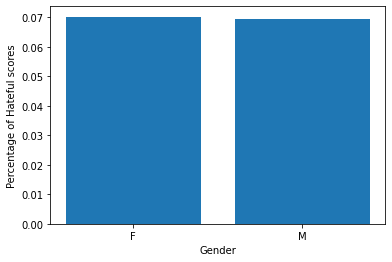

,gender,Hate_score
0,F,7.02
1,M,6.96


In [185]:
# Group the data by "gender" and calculate the percentage of "Hateful" scores
grouped = df.groupby("gender")["Hate_score"].apply(lambda x: (x == "Hateful").mean()).reset_index()

# Plot the percentage of "Hateful" scores for each gender
plt.bar(grouped["gender"], grouped["Hate_score"])
plt.xlabel("Gender")
plt.ylabel("Percentage of Hateful scores")
plt.show()
grouped['Hate_score'] = grouped['Hate_score'].multiply(100).round(2)
display(grouped)

In [186]:
# Create a contingency table for the relationship between gender and Hate_score
ct = pd.crosstab(df['gender'], df['Hate_score'], normalize='index')
print(ct)

Hate_score   Hateful  Non-Hateful
gender                           
F           0.070215     0.929785
M           0.069591     0.930409


In [187]:
df = final_df
df['Hate_score'] = np.where(df['Hate_score'] == 'Hateful', 1, 0)

model = ols('Hate_score ~ gender + parliamentary_group + gender:parliamentary_group', data=df).fit()

# Conduct ANOVA test
aov_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(aov_table)

                                  sum_sq        df          F        PR(>F)
gender                          0.138866       1.0   2.140862  1.434232e-01
parliamentary_group             4.540103       4.0  17.498370  2.293441e-14
gender:parliamentary_group      1.944029       4.0   7.492638  4.968521e-06
Residual                    10454.885470  161180.0        NaN           NaN


In [188]:
# Conduct Tukey's HSD test
tukey = pairwise_tukeyhsd(df['Hate_score'], df['gender'] + '*' + df['parliamentary_group'])

In [189]:
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
tukey_df = tukey_df[tukey_df['reject'] == True]
tukey_df = tukey_df.sort_values(by='meandiff', ascending=False)
display(tukey_df)

,group1,group2,meandiff,p-adj,lower,upper,reject
15,F*FDI,M*M5S,0.0304,0.0010,0.0185,0.0423,True
40,M*FDI,M*M5S,0.0260,0.0010,0.0136,0.0384,True
42,M*LEGA,M*M5S,0.0243,0.0010,0.0132,0.0355,True
37,M*AzIV,M*M5S,0.0218,0.0010,0.0104,0.0332,True
28,F*M5S,M*M5S,0.0211,0.0371,0.0006,0.0415,True
11,F*FDI,F*PD,0.0152,0.0010,0.0055,0.0250,True
33,F*PD,M*M5S,0.0152,0.0107,0.0019,0.0284,True
12,F*FDI,M*AzIV,0.0086,0.0053,0.0015,0.0158,True
4,F*AzIV,M*AzIV,-0.0092,0.0206,-0.0176,-0.0007,True
32,F*PD,M*LEGA,-0.0092,0.0386,-0.0181,-0.0002,True


In [171]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
df = final_df

# convert categorical variables to factors
df['gender'] = df['gender'].astype('category')
df['parliamentary_group'] = df['parliamentary_group'].astype('category')
df['Hate_score'] = df['Hate_score'].astype('category')
df['Sentiment'] = df['Sentiment'].astype('category')

# standardize the predictors
scaler = StandardScaler()
df[['followers_count']] = scaler.fit_transform(df[['followers_count']])

# create a multilevel model
mlogit = sm.GLM.from_formula("Hate_score ~ Sentiment + followers_count + C(gender) + C(parliamentary_group)", 
                              family=sm.families.Binomial(), data=df)

# fit the model
model_fit = mlogit.fit()

# summarize the results
print(model_fit.summary())

                                 Generalized Linear Model Regression Results                                  
Dep. Variable:     ['Hate_score[Hateful]', 'Hate_score[Non-Hateful]']   No. Observations:               161190
Model:                                                            GLM   Df Residuals:                   161182
Model Family:                                                Binomial   Df Model:                            7
Link Function:                                                  logit   Scale:                          1.0000
Method:                                                          IRLS   Log-Likelihood:                -40692.
Date:                                                Tue, 07 Feb 2023   Deviance:                       81383.
Time:                                                        16:56:20   Pearson chi2:                 1.61e+05
No. Iterations:                                                     6                                         
C

In [172]:
final_df

,Tweet_ID,Hate_score,followers_count,gender,parliamentary_group,Sentiment
0,1610630350279004160,Hateful,-0.773593,M,PD,negative
1,1610630350279004160,Non-Hateful,-0.773593,M,PD,negative
2,1610630350279004160,Hateful,-0.773593,M,PD,negative
3,1610630350279004160,Non-Hateful,-0.773593,M,PD,negative
4,1610630350279004160,Non-Hateful,-0.773593,M,PD,negative
...,...,...,...,...,...,...
161185,1618874638393839617,Non-Hateful,-0.796894,M,FDI,positive
161186,1618874638393839617,Non-Hateful,-0.796894,M,FDI,positive
161187,1618874638393839617,Hateful,-0.796894,M,FDI,positive
161188,1618874638393839617,Non-Hateful,-0.796894,M,FDI,positive
